In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import lightgbm as lgb

In [2]:
air_reserve = pd.read_csv('https://github.com/kilee722/Recruit/raw/main/raw_dataset/air_reserve.csv', 
                          dtype={'air_store_id': str, 'reserve_visitors': np.int32}, parse_dates=['visit_datetime', 'reserve_datetime'])
air_store_info = pd.read_csv('https://github.com/kilee722/Recruit/raw/main/raw_dataset/air_store_info.csv',
                             dtype={'air_store_id': str, 'air_genre_name': str, 'air_area_name': str, 'latitude': np.float32, 'longitude': np.float32})
air_visit_data = pd.read_csv('https://github.com/kilee722/Recruit/raw/main/raw_dataset/air_visit_data.csv', 
                             dtype={'air_store_id': str, 'visitors': np.int32}, parse_dates=['visit_date'])
date_info = pd.read_csv("https://github.com/kilee722/Recruit/raw/main/raw_dataset/date_info.csv",
                        dtype={'day_of_week': str, 'holiday_flg': bool}, parse_dates=['calendar_date'])
hpg_reserve = pd.read_parquet("https://github.com/kilee722/Recruit/raw/main/raw_dataset/hpg_reserve.parquet")
hpg_store_info = pd.read_csv("https://github.com/kilee722/Recruit/raw/main/raw_dataset/hpg_store_info.csv",
                             dtype={'hpg_store_id': str, 'hpg_genre_name': str, 'hpg_area_name': str, 'latitude': np.float32, 'longitude': np.float32})
store_id_relation = pd.read_csv('https://github.com/kilee722/Recruit/raw/main/raw_dataset/store_id_relation.csv',
                                dtype={'air_store_id': str, 'hpg_store_id': str})

In [3]:
air_reserve_visitors = air_reserve.groupby(['air_store_id', pd.to_datetime(air_reserve.visit_datetime.dt.date)]).sum().reset_index(drop=False)
air_reserve_visitors.rename(columns={'visit_datetime': 'visit_date'}, inplace=True)
air_reserve_visitors = pd.merge(air_reserve_visitors, store_id_relation, how='left', on='air_store_id')
air_reserve_visitors

,air_store_id,visit_date,reserve_visitors,hpg_store_id
0,air_00a91d42b08b08d9,2016-10-31,2,hpg_fbe603376b5980fc
1,air_00a91d42b08b08d9,2016-12-05,9,hpg_fbe603376b5980fc
2,air_00a91d42b08b08d9,2016-12-14,18,hpg_fbe603376b5980fc
3,air_00a91d42b08b08d9,2016-12-17,2,hpg_fbe603376b5980fc
4,air_00a91d42b08b08d9,2016-12-20,4,hpg_fbe603376b5980fc
...,...,...,...,...
29825,air_fea5dc9594450608,2017-04-22,2,hpg_6507818140022452
29826,air_fea5dc9594450608,2017-04-25,2,hpg_6507818140022452
29827,air_fea5dc9594450608,2017-04-28,3,hpg_6507818140022452
29828,air_fea5dc9594450608,2017-05-20,6,hpg_6507818140022452


In [4]:
hpg_reserve.visit_datetime = pd.to_datetime(hpg_reserve.visit_datetime)
hpg_reserve.reserve_datetime = pd.to_datetime(hpg_reserve.reserve_datetime)
hpg_reserve.reserve_visitors = hpg_reserve.reserve_visitors.astype(np.int32)
hpg_reserve_visitors = hpg_reserve.groupby(['hpg_store_id', pd.to_datetime(hpg_reserve.visit_datetime.dt.date)]).sum().reset_index(drop=False)
hpg_reserve_visitors.rename(columns={'visit_datetime': 'visit_date'}, inplace=True)
hpg_reserve_visitors = pd.merge(hpg_reserve_visitors, store_id_relation, how='left', on='hpg_store_id')
hpg_reserve_visitors = hpg_reserve_visitors.loc[~hpg_reserve_visitors.air_store_id.isna().values, :]
hpg_reserve_visitors

,hpg_store_id,visit_date,reserve_visitors,air_store_id
8717,hpg_0183ec352e38903c,2016-01-09,2,air_cbe867adcf44e14f
8718,hpg_0183ec352e38903c,2016-01-11,8,air_cbe867adcf44e14f
8719,hpg_0183ec352e38903c,2016-01-14,11,air_cbe867adcf44e14f
8720,hpg_0183ec352e38903c,2016-01-15,8,air_cbe867adcf44e14f
8721,hpg_0183ec352e38903c,2016-01-18,9,air_cbe867adcf44e14f
...,...,...,...,...
1338634,hpg_fc892fe8d342a787,2017-04-27,5,air_ee3ba9af184c6c82
1338635,hpg_fc892fe8d342a787,2017-04-28,7,air_ee3ba9af184c6c82
1338636,hpg_fc892fe8d342a787,2017-04-29,3,air_ee3ba9af184c6c82
1338637,hpg_fc892fe8d342a787,2017-05-05,2,air_ee3ba9af184c6c82


In [5]:
reserve_visitors = pd.concat([air_reserve_visitors, hpg_reserve_visitors]).groupby(['air_store_id', 'visit_date']).sum().reset_index(drop=False)
reserve_visitors

,air_store_id,visit_date,reserve_visitors
0,air_00a91d42b08b08d9,2016-01-14,2
1,air_00a91d42b08b08d9,2016-01-15,4
2,air_00a91d42b08b08d9,2016-01-16,2
3,air_00a91d42b08b08d9,2016-01-22,2
4,air_00a91d42b08b08d9,2016-01-29,5
...,...,...,...
42188,air_fea5dc9594450608,2017-04-22,4
42189,air_fea5dc9594450608,2017-04-25,4
42190,air_fea5dc9594450608,2017-04-28,6
42191,air_fea5dc9594450608,2017-05-20,12


In [6]:
train = pd.merge(air_visit_data, date_info, how='left', left_on='visit_date', right_on='calendar_date').drop(columns='calendar_date')
# train = pd.merge(train, reserve_visitors, how='left', on=['air_store_id', 'visit_date'])
train

,air_store_id,visit_date,visitors,day_of_week,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,False
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,False
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,False
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,False
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,False
...,...,...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6,Tuesday,False
252104,air_24e8414b9b07decb,2017-04-19,6,Wednesday,False
252105,air_24e8414b9b07decb,2017-04-20,7,Thursday,False
252106,air_24e8414b9b07decb,2017-04-21,8,Friday,False


In [7]:
train['year'] = train['visit_date'].dt.year
train['month'] = train['visit_date'].dt.month
train['day'] = train['visit_date'].dt.day

In [8]:
train

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,year,month,day
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,False,2016,1,13
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,False,2016,1,14
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,False,2016,1,15
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,False,2016,1,16
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,False,2016,1,18
...,...,...,...,...,...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6,Tuesday,False,2017,4,18
252104,air_24e8414b9b07decb,2017-04-19,6,Wednesday,False,2017,4,19
252105,air_24e8414b9b07decb,2017-04-20,7,Thursday,False,2017,4,20
252106,air_24e8414b9b07decb,2017-04-21,8,Friday,False,2017,4,21


In [9]:
train.groupby(['year','month'])[['visitors']].sum()

visitors
year month          
2016 1        152924
     2        159934
     3        189292
     4        182272
     5        179618
     6        175822
     7        455702
     8        408300
     9        414673
     10       436183
     11       413283
     12       497617
2017 1        386848
     2        401462
     3        495487
     4        338236

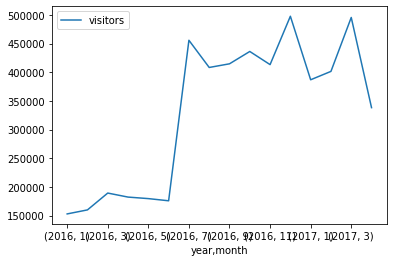

In [10]:
train.groupby(['year','month'])[['visitors']].sum().plot()

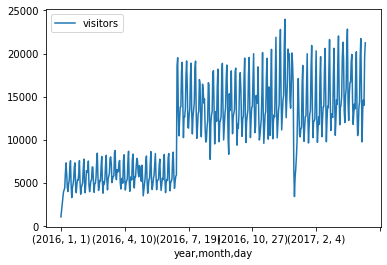

In [11]:
train.groupby(['year','month', 'day'])[['visitors']].sum().plot()

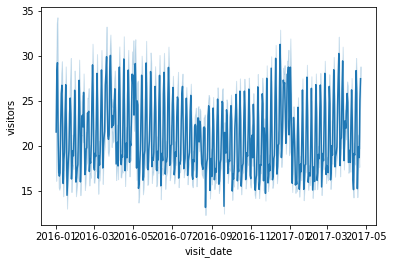

In [12]:
sns.lineplot(x='visit_date', y='visitors', data=train)

In [17]:
air_store_info

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695126,135.197845
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695126,135.197845
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695126,135.197845
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695126,135.197845
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658070,139.751602
...,...,...,...,...,...
824,air_9bf595ef095572fb,International cuisine,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704056
825,air_764f71040a413d4d,Asian,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704056
826,air_10bbe8acd943d8f6,Asian,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704056
827,air_7514d90009613cd6,Karaoke/Party,Hokkaidō Sapporo-shi Minami 3 Jōnishi,43.055462,141.340958


In [18]:
train

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,year,month,day
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,False,2016,1,13
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,False,2016,1,14
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,False,2016,1,15
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,False,2016,1,16
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,False,2016,1,18
...,...,...,...,...,...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6,Tuesday,False,2017,4,18
252104,air_24e8414b9b07decb,2017-04-19,6,Wednesday,False,2017,4,19
252105,air_24e8414b9b07decb,2017-04-20,7,Thursday,False,2017,4,20
252106,air_24e8414b9b07decb,2017-04-21,8,Friday,False,2017,4,21


In [19]:
air_store_info[['Prefecture', 'Municipality', 'District']] = air_store_info.air_area_name.str.split(" ", n=2, expand=True)

In [20]:
air_store_info.drop(columns = "air_area_name", inplace = True)

In [21]:
air_store_info

,air_store_id,air_genre_name,latitude,longitude,Prefecture,Municipality,District
0,air_0f0cdeee6c9bf3d7,Italian/French,34.695126,135.197845,Hyōgo-ken,Kōbe-shi,Kumoidōri
1,air_7cc17a324ae5c7dc,Italian/French,34.695126,135.197845,Hyōgo-ken,Kōbe-shi,Kumoidōri
2,air_fee8dcf4d619598e,Italian/French,34.695126,135.197845,Hyōgo-ken,Kōbe-shi,Kumoidōri
3,air_a17f0778617c76e2,Italian/French,34.695126,135.197845,Hyōgo-ken,Kōbe-shi,Kumoidōri
4,air_83db5aff8f50478e,Italian/French,35.658070,139.751602,Tōkyō-to,Minato-ku,Shibakōen
...,...,...,...,...,...,...,...
824,air_9bf595ef095572fb,International cuisine,35.661777,139.704056,Tōkyō-to,Shibuya-ku,Shibuya
825,air_764f71040a413d4d,Asian,35.661777,139.704056,Tōkyō-to,Shibuya-ku,Shibuya
826,air_10bbe8acd943d8f6,Asian,35.661777,139.704056,Tōkyō-to,Shibuya-ku,Shibuya
827,air_7514d90009613cd6,Karaoke/Party,43.055462,141.340958,Hokkaidō,Sapporo-shi,Minami 3 Jōnishi


In [22]:
final_train =  train.merge(air_store_info, how = "left", on="air_store_id")

In [23]:
print(date_info)

    calendar_date day_of_week  holiday_flg
0      2016-01-01      Friday         True
1      2016-01-02    Saturday         True
2      2016-01-03      Sunday         True
3      2016-01-04      Monday        False
4      2016-01-05     Tuesday        False
..            ...         ...          ...
512    2017-05-27    Saturday        False
513    2017-05-28      Sunday        False
514    2017-05-29      Monday        False
515    2017-05-30     Tuesday        False
516    2017-05-31   Wednesday        False

[517 rows x 3 columns]


In [24]:
final_train

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,year,month,day,air_genre_name,latitude,longitude,Prefecture,Municipality,District
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,False,2016,1,13,Dining bar,35.658070,139.751602,Tōkyō-to,Minato-ku,Shibakōen
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,False,2016,1,14,Dining bar,35.658070,139.751602,Tōkyō-to,Minato-ku,Shibakōen
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,False,2016,1,15,Dining bar,35.658070,139.751602,Tōkyō-to,Minato-ku,Shibakōen
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,False,2016,1,16,Dining bar,35.658070,139.751602,Tōkyō-to,Minato-ku,Shibakōen
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,False,2016,1,18,Dining bar,35.658070,139.751602,Tōkyō-to,Minato-ku,Shibakōen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6,Tuesday,False,2017,4,18,Other,35.653217,139.711029,Tōkyō-to,Shibuya-ku,Higashi
252104,air_24e8414b9b07decb,2017-04-19,6,Wednesday,False,2017,4,19,Other,35.653217,139.711029,Tōkyō-to,Shibuya-ku,Higashi
252105,air_24e8414b9b07decb,2017-04-20,7,Thursday,False,2017,4,20,Other,35.653217,139.711029,Tōkyō-to,Shibuya-ku,Higashi
252106,air_24e8414b9b07decb,2017-04-21,8,Friday,False,2017,4,21,Other,35.653217,139.711029,Tōkyō-to,Shibuya-ku,Higashi


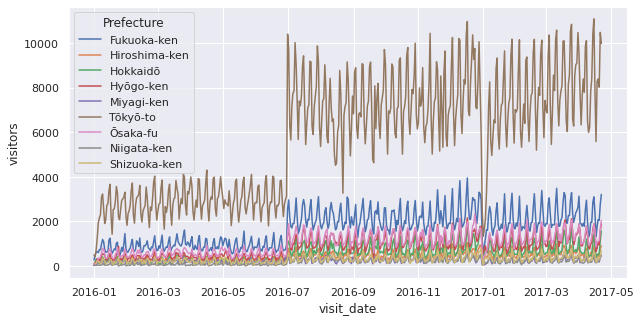

In [25]:
sns.lineplot(x = 'visit_date', y = 'visitors', hue = 'Prefecture',data = final_train.groupby(['visit_date', 'Prefecture'])[['visitors']].sum())

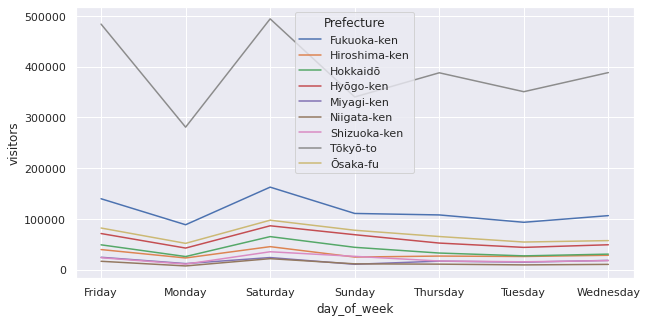

In [26]:
sns.lineplot(x = 'day_of_week', y = 'visitors', hue = 'Prefecture',data = final_train.groupby(['day_of_week', 'Prefecture'])[['visitors']].sum())

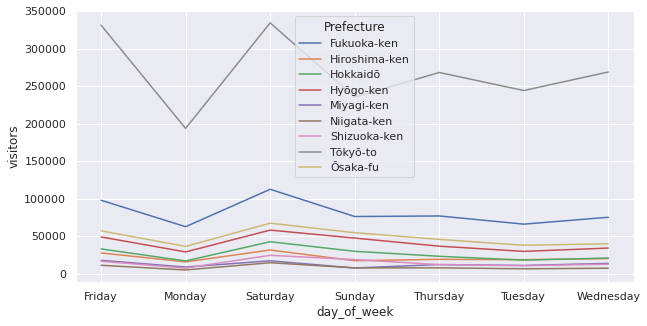

In [27]:
a = final_train.query("year == 2016")
sns.lineplot(x = 'day_of_week', y = 'visitors', hue = 'Prefecture',data = a.groupby(['day_of_week', 'Prefecture'])[['visitors']].sum())

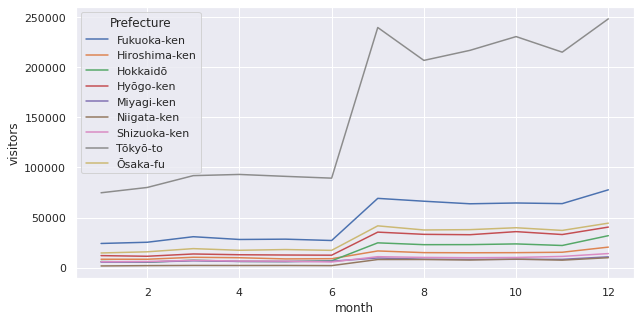

In [28]:
a = final_train.query("year == 2016")
sns.lineplot(x = 'month', y = 'visitors', hue = 'Prefecture',data = a.groupby(['month', 'Prefecture'])[['visitors']].sum())

In [29]:
final_train

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,year,month,day,air_genre_name,latitude,longitude,Prefecture,Municipality,District
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,False,2016,1,13,Dining bar,35.658070,139.751602,Tōkyō-to,Minato-ku,Shibakōen
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,False,2016,1,14,Dining bar,35.658070,139.751602,Tōkyō-to,Minato-ku,Shibakōen
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,False,2016,1,15,Dining bar,35.658070,139.751602,Tōkyō-to,Minato-ku,Shibakōen
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,False,2016,1,16,Dining bar,35.658070,139.751602,Tōkyō-to,Minato-ku,Shibakōen
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,False,2016,1,18,Dining bar,35.658070,139.751602,Tōkyō-to,Minato-ku,Shibakōen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6,Tuesday,False,2017,4,18,Other,35.653217,139.711029,Tōkyō-to,Shibuya-ku,Higashi
252104,air_24e8414b9b07decb,2017-04-19,6,Wednesday,False,2017,4,19,Other,35.653217,139.711029,Tōkyō-to,Shibuya-ku,Higashi
252105,air_24e8414b9b07decb,2017-04-20,7,Thursday,False,2017,4,20,Other,35.653217,139.711029,Tōkyō-to,Shibuya-ku,Higashi
252106,air_24e8414b9b07decb,2017-04-21,8,Friday,False,2017,4,21,Other,35.653217,139.711029,Tōkyō-to,Shibuya-ku,Higashi


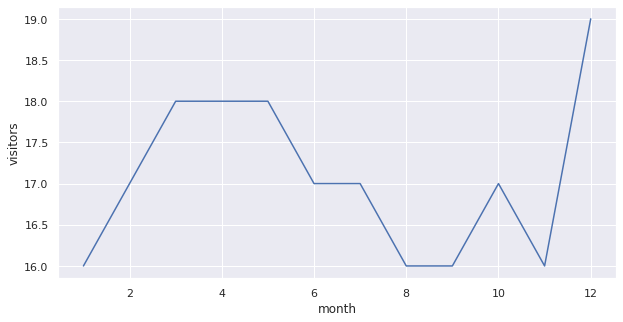

In [30]:
a = final_train.query("air_store_id == 'air_24e8414b9b07decb'")
b= final_train.groupby(["month"])[['visitors']].median()
sns.lineplot(x = 'month', y = 'visitors',data = b)

In [31]:
a

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,year,month,day,air_genre_name,latitude,longitude,Prefecture,Municipality,District
251874,air_24e8414b9b07decb,2016-07-01,7,Friday,False,2016,7,1,Other,35.653217,139.711029,Tōkyō-to,Shibuya-ku,Higashi
251875,air_24e8414b9b07decb,2016-07-02,4,Saturday,False,2016,7,2,Other,35.653217,139.711029,Tōkyō-to,Shibuya-ku,Higashi
251876,air_24e8414b9b07decb,2016-07-04,2,Monday,False,2016,7,4,Other,35.653217,139.711029,Tōkyō-to,Shibuya-ku,Higashi
251877,air_24e8414b9b07decb,2016-07-05,5,Tuesday,False,2016,7,5,Other,35.653217,139.711029,Tōkyō-to,Shibuya-ku,Higashi
251878,air_24e8414b9b07decb,2016-07-06,6,Wednesday,False,2016,7,6,Other,35.653217,139.711029,Tōkyō-to,Shibuya-ku,Higashi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6,Tuesday,False,2017,4,18,Other,35.653217,139.711029,Tōkyō-to,Shibuya-ku,Higashi
252104,air_24e8414b9b07decb,2017-04-19,6,Wednesday,False,2017,4,19,Other,35.653217,139.711029,Tōkyō-to,Shibuya-ku,Higashi
252105,air_24e8414b9b07decb,2017-04-20,7,Thursday,False,2017,4,20,Other,35.653217,139.711029,Tōkyō-to,Shibuya-ku,Higashi
252106,air_24e8414b9b07decb,2017-04-21,8,Friday,False,2017,4,21,Other,35.653217,139.711029,Tōkyō-to,Shibuya-ku,Higashi


In [32]:
a

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,year,month,day,air_genre_name,latitude,longitude,Prefecture,Municipality,District
251874,air_24e8414b9b07decb,2016-07-01,7,Friday,False,2016,7,1,Other,35.653217,139.711029,Tōkyō-to,Shibuya-ku,Higashi
251875,air_24e8414b9b07decb,2016-07-02,4,Saturday,False,2016,7,2,Other,35.653217,139.711029,Tōkyō-to,Shibuya-ku,Higashi
251876,air_24e8414b9b07decb,2016-07-04,2,Monday,False,2016,7,4,Other,35.653217,139.711029,Tōkyō-to,Shibuya-ku,Higashi
251877,air_24e8414b9b07decb,2016-07-05,5,Tuesday,False,2016,7,5,Other,35.653217,139.711029,Tōkyō-to,Shibuya-ku,Higashi
251878,air_24e8414b9b07decb,2016-07-06,6,Wednesday,False,2016,7,6,Other,35.653217,139.711029,Tōkyō-to,Shibuya-ku,Higashi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6,Tuesday,False,2017,4,18,Other,35.653217,139.711029,Tōkyō-to,Shibuya-ku,Higashi
252104,air_24e8414b9b07decb,2017-04-19,6,Wednesday,False,2017,4,19,Other,35.653217,139.711029,Tōkyō-to,Shibuya-ku,Higashi
252105,air_24e8414b9b07decb,2017-04-20,7,Thursday,False,2017,4,20,Other,35.653217,139.711029,Tōkyō-to,Shibuya-ku,Higashi
252106,air_24e8414b9b07decb,2017-04-21,8,Friday,False,2017,4,21,Other,35.653217,139.711029,Tōkyō-to,Shibuya-ku,Higashi


In [33]:
final_train['holiday_flg'] = pd.Categorical(final_train["holiday_flg"].values)


(0.0, 75.0)

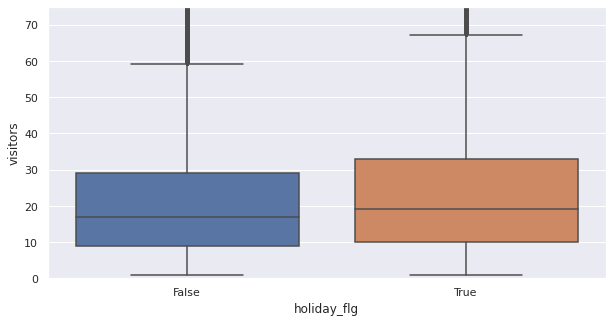

In [34]:
ax = sns.boxplot(x ="holiday_flg", y='visitors' , data= final_train)
ax.set_ylim(0, 75)

In [35]:
final_train.columns

Index(['air_store_id', 'visit_date', 'visitors', 'day_of_week', 'holiday_flg',
       'year', 'month', 'day', 'air_genre_name', 'latitude', 'longitude',
       'Prefecture', 'Municipality', 'District'],
      dtype='object')

In [36]:
c = final_train.groupby(['day_of_week', 'holiday_flg'])[['visitors']].median()
c

visitors
day_of_week holiday_flg          
Friday      False              19
            True               23
Monday      False              13
            True               18
Saturday    False              22
            True               20
Sunday      False              19
            True               20
Thursday    False              15
            True               19
Tuesday     False              14
            True               22
Wednesday   False              16
            True               18

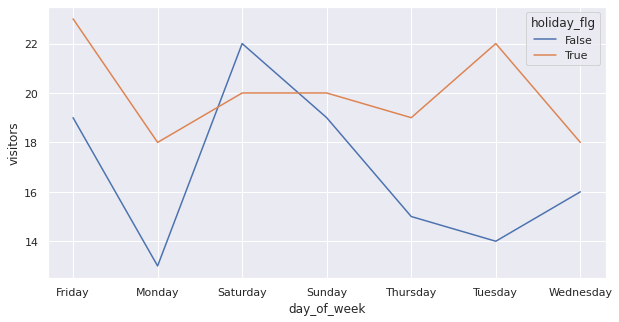

In [37]:
sns.lineplot(x = 'day_of_week', y = 'visitors',hue = 'holiday_flg', data = c)

In [38]:
final_train['visitors'].median()

17.0

In [39]:
def cyl_enc(value, max_value):
  x_comp = np.cos(2*np.pi * value/max_value)
  y_comp = np.sin(2*np.pi * value/max_value)
  return x_comp, y_comp


In [40]:
final_train.visit_date.astype(str)

0         2016-01-13
1         2016-01-14
2         2016-01-15
3         2016-01-16
4         2016-01-18
             ...    
252103    2017-04-18
252104    2017-04-19
252105    2017-04-20
252106    2017-04-21
252107    2017-04-22
Name: visit_date, Length: 252108, dtype: object

In [41]:
cyl_enc(final_train.visit_date.dt.dayofweek.values, 6)

(array([-0.5, -1. , -0.5, ..., -1. , -0.5,  0.5]),
 array([ 8.66025404e-01,  1.22464680e-16, -8.66025404e-01, ...,
         1.22464680e-16, -8.66025404e-01, -8.66025404e-01]))

In [42]:
x, y = cyl_enc(final_train.visit_date.dt.month.values, 12)

In [43]:
x

array([ 0.8660254,  0.8660254,  0.8660254, ..., -0.5      , -0.5      ,
       -0.5      ])

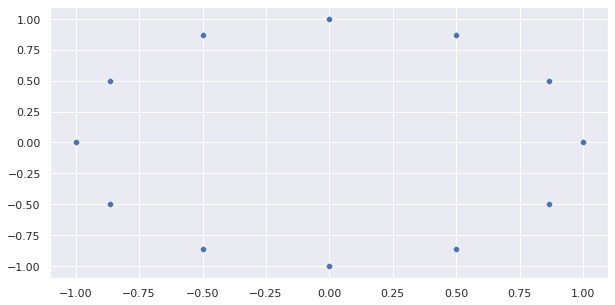

In [44]:
sns.scatterplot(x = x[1:1000], y = y[1:1000])

In [45]:
final_train.query("year == 2016").groupby(["month"]).air_store_id.count()

# Observation: The number of restaurants surveyed was increased after June 2016

month
1      7320
2      7604
3      8278
4      8089
5      8161
6      8247
7     21427
8     20675
9     20829
10    21466
11    20924
12    21515
Name: air_store_id, dtype: int64

In [46]:
final_train

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,year,month,day,air_genre_name,latitude,longitude,Prefecture,Municipality,District
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,False,2016,1,13,Dining bar,35.658070,139.751602,Tōkyō-to,Minato-ku,Shibakōen
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,False,2016,1,14,Dining bar,35.658070,139.751602,Tōkyō-to,Minato-ku,Shibakōen
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,False,2016,1,15,Dining bar,35.658070,139.751602,Tōkyō-to,Minato-ku,Shibakōen
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,False,2016,1,16,Dining bar,35.658070,139.751602,Tōkyō-to,Minato-ku,Shibakōen
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,False,2016,1,18,Dining bar,35.658070,139.751602,Tōkyō-to,Minato-ku,Shibakōen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6,Tuesday,False,2017,4,18,Other,35.653217,139.711029,Tōkyō-to,Shibuya-ku,Higashi
252104,air_24e8414b9b07decb,2017-04-19,6,Wednesday,False,2017,4,19,Other,35.653217,139.711029,Tōkyō-to,Shibuya-ku,Higashi
252105,air_24e8414b9b07decb,2017-04-20,7,Thursday,False,2017,4,20,Other,35.653217,139.711029,Tōkyō-to,Shibuya-ku,Higashi
252106,air_24e8414b9b07decb,2017-04-21,8,Friday,False,2017,4,21,Other,35.653217,139.711029,Tōkyō-to,Shibuya-ku,Higashi


In [47]:
final_train.air_store_id.value_counts()

air_5c817ef28f236bdf    477
air_a083834e7ffe187e    476
air_d97dabf7aae60da5    476
air_36bcf77d3382d36e    476
air_60a7057184ec7ec7    475
                       ... 
air_1c0b150f9e696a5f     51
air_a17f0778617c76e2     47
air_789103bf53b8096b     41
air_a9a380530c1e121f     40
air_900d755ebd2f7bbd     20
Name: air_store_id, Length: 829, dtype: int64

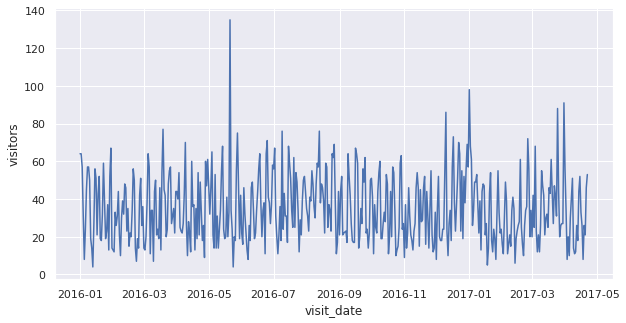

In [48]:
z = final_train.query("air_store_id == 'air_60a7057184ec7ec7'")
sns.lineplot(x = "visit_date", y = "visitors" , data=z)

In [49]:
final_train.air_store_id = final_train.air_store_id.astype('category')

In [50]:
final_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252108 entries, 0 to 252107
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   air_store_id    252108 non-null  category      
 1   visit_date      252108 non-null  datetime64[ns]
 2   visitors        252108 non-null  int32         
 3   day_of_week     252108 non-null  object        
 4   holiday_flg     252108 non-null  category      
 5   year            252108 non-null  int64         
 6   month           252108 non-null  int64         
 7   day             252108 non-null  int64         
 8   air_genre_name  252108 non-null  object        
 9   latitude        252108 non-null  float32       
 10  longitude       252108 non-null  float32       
 11  Prefecture      252108 non-null  object        
 12  Municipality    252108 non-null  object        
 13  District        252108 non-null  object        
dtypes: category(2), datetime64[ns](1), f

In [51]:
x_dow, y_dow = cyl_enc(final_train.visit_date.dt.dayofweek.values, 6)

In [52]:
final_train['x_dow'] = x_dow
final_train['y_dow'] = y_dow


In [53]:
x_mon, y_mon = cyl_enc(final_train.visit_date.dt.month.values, 12)
final_train['x_mon'] = x_mon
final_train['y_mon'] = y_mon

In [54]:
final_train.drop(columns = ['visit_date', 'day_of_week', 'year', 'month', 'day'], inplace= True)

In [55]:
final_train

,air_store_id,visitors,holiday_flg,air_genre_name,latitude,longitude,Prefecture,Municipality,District,x_dow,y_dow,x_mon,y_mon
0,air_ba937bf13d40fb24,25,False,Dining bar,35.658070,139.751602,Tōkyō-to,Minato-ku,Shibakōen,-0.5,8.660254e-01,0.866025,0.500000
1,air_ba937bf13d40fb24,32,False,Dining bar,35.658070,139.751602,Tōkyō-to,Minato-ku,Shibakōen,-1.0,1.224647e-16,0.866025,0.500000
2,air_ba937bf13d40fb24,29,False,Dining bar,35.658070,139.751602,Tōkyō-to,Minato-ku,Shibakōen,-0.5,-8.660254e-01,0.866025,0.500000
3,air_ba937bf13d40fb24,22,False,Dining bar,35.658070,139.751602,Tōkyō-to,Minato-ku,Shibakōen,0.5,-8.660254e-01,0.866025,0.500000
4,air_ba937bf13d40fb24,6,False,Dining bar,35.658070,139.751602,Tōkyō-to,Minato-ku,Shibakōen,1.0,0.000000e+00,0.866025,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
252103,air_24e8414b9b07decb,6,False,Other,35.653217,139.711029,Tōkyō-to,Shibuya-ku,Higashi,0.5,8.660254e-01,-0.500000,0.866025
252104,air_24e8414b9b07decb,6,False,Other,35.653217,139.711029,Tōkyō-to,Shibuya-ku,Higashi,-0.5,8.660254e-01,-0.500000,0.866025
252105,air_24e8414b9b07decb,7,False,Other,35.653217,139.711029,Tōkyō-to,Shibuya-ku,Higashi,-1.0,1.224647e-16,-0.500000,0.866025
252106,air_24e8414b9b07decb,8,False,Other,35.653217,139.711029,Tōkyō-to,Shibuya-ku,Higashi,-0.5,-8.660254e-01,-0.500000,0.866025


In [56]:
final_train.air_genre_name = final_train.air_genre_name.astype('category')
final_train.Prefecture = final_train.Prefecture.astype('category')
final_train.Municipality = final_train.Municipality.astype('category')
final_train.District = final_train.District.astype('category')

In [57]:
final_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252108 entries, 0 to 252107
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   air_store_id    252108 non-null  category
 1   visitors        252108 non-null  int32   
 2   holiday_flg     252108 non-null  category
 3   air_genre_name  252108 non-null  category
 4   latitude        252108 non-null  float32 
 5   longitude       252108 non-null  float32 
 6   Prefecture      252108 non-null  category
 7   Municipality    252108 non-null  category
 8   District        252108 non-null  category
 9   x_dow           252108 non-null  float64 
 10  y_dow           252108 non-null  float64 
 11  x_mon           252108 non-null  float64 
 12  y_mon           252108 non-null  float64 
dtypes: category(6), float32(2), float64(4), int32(1)
memory usage: 24.2 MB


In [59]:
x = final_train.drop(columns = 'visitors')
y = final_train["visitors"]

In [60]:
train_data = lgb.Dataset(x, label=y)

In [61]:
param = {'num_leaves': 31, 'objective':'regression', 'metric': 'l2'}


In [62]:
num_round = 200
bst = lgb.train(param, train_data, num_round, verbose_eval=1)

In [63]:
bst

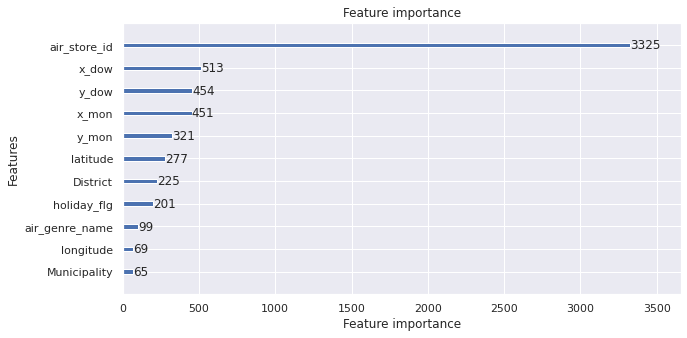

In [64]:
lgb.plot_importance(bst)

In [66]:
final_train.to_csv("recruit_data.csv")

In [ ]:
final_train.to_csv("recruit_data.csv.gz")